# EDA notebook

Expects the table `raw_power` to be created by ingester script `py/ingest_sqlite.py`.

In [1]:
import datetime
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
DB_PATH = 'data/housepower.sqlite'

def execute_sql_query(query):
    conn = sqlite3.connect(DB_PATH)
    cur = conn.execute(query)
    ret = cur.fetchall()
    col_names = [desc[0] for desc in cur.description]
    conn.close()
    return pd.DataFrame(ret, columns=col_names)

### Number of rows, timestamp interval

In [3]:
execute_sql_query("""
SELECT
    COUNT(*) AS n_rows,
    MIN(ts) AS min_time,
    MAX(ts) AS max_time
FROM raw_power;
""")

,n_rows,min_time,max_time
0,2075259,2006-12-16 17:24:00,2010-11-26 21:02:00


### Missing or duplicate timestamps (NULL timestamps were excluded by ingester script)

Validate that the timestamp column does not have duplicate values:

In [4]:
execute_sql_query("""
SELECT
  COUNT(*) AS n_timestamps,
  COUNT(DISTINCT ts) AS n_distinct_timestamps,
  COUNT(*) - COUNT(DISTINCT ts) AS diff
FROM raw_power;
""")

,n_timestamps,n_distinct_timestamps,diff
0,2075259,2075259,0


Validate that the timestamp column does not have gaps, i.e. it is a full minute-grid:

In [5]:
execute_sql_query("""
SELECT
  COUNT(*) as n_timestamps,
  (STRFTIME('%s', MAX(ts)) - STRFTIME('%s', MIN(ts))) / 60 + 1 as n_minutes_grid,
  COUNT(*) - ((STRFTIME('%s', MAX(ts)) - STRFTIME('%s', MIN(ts))) / 60 + 1) as diff
FROM raw_power;
""")

,n_timestamps,n_minutes_grid,diff
0,2075259,2075259,0


### Missing values - number of NULLs per row

Any row is either empty entirely, including target variable, or entirely full with all values non-NULL:

In [6]:
execute_sql_query(
"""
SELECT 
    SUM(CASE WHEN n_present = 0 THEN 1 ELSE 0 END) AS fully_empty,
    SUM(CASE WHEN n_present BETWEEN 1 AND 6 THEN 1 ELSE 0 END) AS partially_empty,
    SUM(CASE WHEN n_present = 7 THEN 1 ELSE 0 END) AS fully_filled
FROM (
    SELECT
        (global_active_power IS NOT NULL) +
        (global_reactive_power IS NOT NULL) +
        (voltage IS NOT NULL) +
        (global_intensity IS NOT NULL) +
        (sub_1 IS NOT NULL) +
        (sub_2 IS NOT NULL) +
        (sub_3 IS NOT NULL) AS n_present
    FROM raw_power
) AS t;
""")

,fully_empty,partially_empty,fully_filled
0,25979,0,2049280


### Missing values - rate of empty rows per month

In [7]:
df_monthly_empty = execute_sql_query("""
SELECT
    DATE(STRFTIME('%Y-%m-01 00:00:00', ts)) as month,
    1.0 * SUM(global_active_power IS NULL) / COUNT(*) empty_rate
FROM raw_power
GROUP BY month
ORDER BY month;
""")
df_monthly_empty['month'] = pd.to_datetime(df_monthly_empty['month']).dt.date

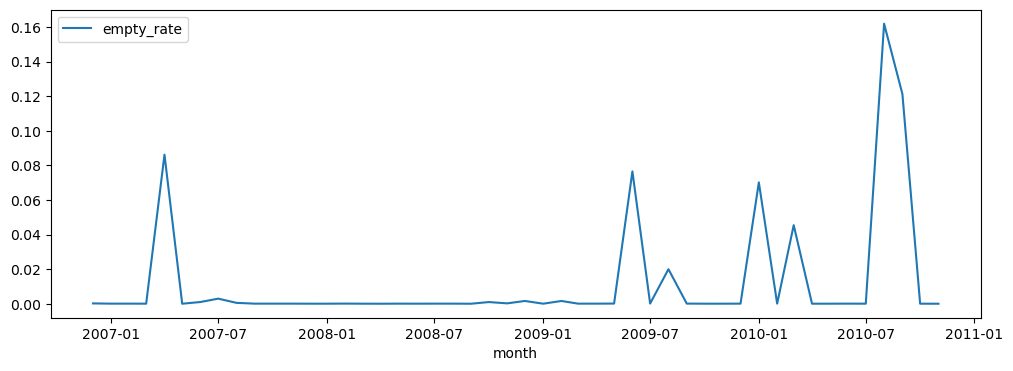

In [8]:
df_monthly_empty.plot(x='month', y='empty_rate', figsize=(12, 4))
plt.show()

### Missing values - rate of empty rows per day (heatmap)

In [9]:
df_daily_empty = execute_sql_query("""
SELECT
    DATE(STRFTIME('%Y-%m-%d 00:00:00', ts)) as day,
    1.0 * SUM(global_active_power IS NULL) / COUNT(*) empty_rate
FROM raw_power
GROUP BY day
ORDER BY day;
""")

df_daily_empty['day'] = pd.to_datetime(df_daily_empty['day'])
df_daily_empty['month'] = df_daily_empty['day'].dt.to_period('M')
df_daily_empty['day'] = df_daily_empty['day'].dt.day

df_daily_empty_wide = df_daily_empty.set_index(['month', 'day'])['empty_rate'].unstack(level=0)

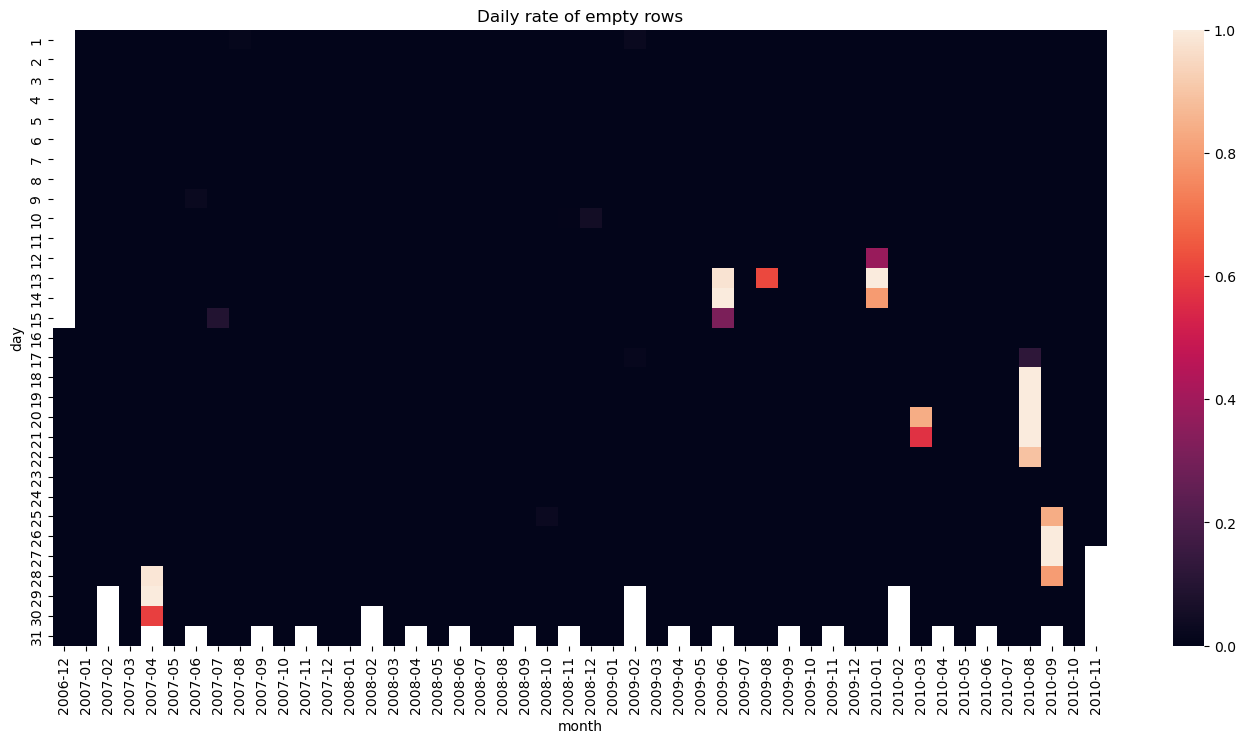

In [10]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.heatmap(df_daily_empty_wide, ax=ax)
plt.title('Daily rate of empty rows')
plt.show()